# Lab 5: RNN for Part-of-Speech Tagging

## Mục tiêu
- Hiểu và triển khai mô hình RNN cho bài toán POS Tagging
- Sử dụng LSTM/GRU để dự đoán nhãn từ loại
- Đánh giá hiệu suất mô hình trên tập test


In [ ]:
# Import các thư viện cần thiết
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import os
import warnings
warnings.filterwarnings('ignore')

print("Đã import các thư viện thành công!")


Đã import các thư viện thành công!


## 1. Load và Preprocess Data


In [ ]:
# Load dữ liệu từ UD_English-EWT CONLLU files
def load_conllu_file(file_path):
    """Load và parse file CONLLU format"""
    sentences = []
    current_sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Bỏ qua comment lines và empty lines
            if line.startswith('#') or not line:
                if not line and current_sentence:
                    # Kết thúc một câu
                    sentences.append(current_sentence)
                    current_sentence = []
                continue

            # Parse CONLLU line: ID, FORM, LEMMA, UPOS, XPOS, FEATS, HEAD, DEPREL, DEPS, MISC
            parts = line.split('\t')
            if len(parts) >= 4:
                word = parts[1]  # FORM (column 2)
                pos_tag = parts[3]  # UPOS (column 4)
                current_sentence.append((word, pos_tag))

        # Thêm câu cuối cùng nếu có
        if current_sentence:
            sentences.append(current_sentence)

    return sentences

# Đường dẫn đến dataset
data_dir = '/content/data/UD_English-EWT'
train_file = os.path.join(data_dir, 'en_ewt-ud-train.conllu')
dev_file = os.path.join(data_dir, 'en_ewt-ud-dev.conllu')
test_file = os.path.join(data_dir, 'en_ewt-ud-test.conllu')

# Load dữ liệu
print("Đang load dữ liệu từ UD_English-EWT...")
train_data = load_conllu_file(train_file)
dev_data = load_conllu_file(dev_file)
test_data = load_conllu_file(test_file)

# Gộp train và dev để build vocabulary (sau đó sẽ chia lại)
all_data = train_data + dev_data

print(f"Train: {len(train_data)} câu")
print(f"Dev: {len(dev_data)} câu")
print(f"Test: {len(test_data)} câu")
print(f"Tổng số câu: {len(all_data)}")
print(f"\nVí dụ câu đầu tiên:")
print(all_data[0])


Đang load dữ liệu từ UD_English-EWT...
Train: 12544 câu
Dev: 2001 câu
Test: 2077 câu
Tổng số câu: 14545

Ví dụ câu đầu tiên:
[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN'), ('-', 'PUNCT'), ('Ani', 'PROPN'), (',', 'PUNCT'), ('the', 'DET'), ('preacher', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('mosque', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('town', 'NOUN'), ('of', 'ADP'), ('Qaim', 'PROPN'), (',', 'PUNCT'), ('near', 'ADP'), ('the', 'DET'), ('Syrian', 'ADJ'), ('border', 'NOUN'), ('.', 'PUNCT')]


In [ ]:
# Tạo vocabulary cho words và tags
def build_vocab(data, min_freq=2):
    """Xây dựng vocabulary cho words và tags"""
    word_counter = Counter()
    tag_set = set()

    for sentence in data:
        for word, tag in sentence:
            word_counter[word.lower()] += 1
            tag_set.add(tag)

    # Tạo word_to_idx
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, count in word_counter.items():
        if count >= min_freq:
            word_to_idx[word] = idx
            idx += 1

    # Tạo tag_to_idx
    tag_to_idx = {tag: i for i, tag in enumerate(sorted(tag_set))}
    idx_to_tag = {i: tag for tag, i in tag_to_idx.items()}

    return word_to_idx, tag_to_idx, idx_to_tag

# Build vocabulary từ tất cả dữ liệu (train + dev)
word_to_idx, tag_to_idx, idx_to_tag = build_vocab(all_data)

print(f"Số lượng từ trong vocabulary: {len(word_to_idx)}")
print(f"Số lượng nhãn POS: {len(tag_to_idx)}")
print(f"\nTất cả nhãn POS: {sorted(tag_to_idx.keys())}")


Số lượng từ trong vocabulary: 9760
Số lượng nhãn POS: 18

Tất cả nhãn POS: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']


In [ ]:
# Dữ liệu đã được chia sẵn từ CONLLU files
# train_data, dev_data, test_data đã được load ở trên
# Sử dụng dev_data làm validation set
val_data = dev_data

print(f"Train: {len(train_data)} câu")
print(f"Validation: {len(val_data)} câu")
print(f"Test: {len(test_data)} câu")


Train: 12544 câu
Validation: 2001 câu
Test: 2077 câu


## 2. Tạo Dataset và DataLoader


In [ ]:
class POSTaggingDataset(Dataset):
    """Dataset cho POS Tagging"""
    def __init__(self, data, word_to_idx, tag_to_idx):
        self.data = data
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]
        words = [word.lower() for word, _ in sentence]
        tags = [tag for _, tag in sentence]

        # Chuyển đổi sang indices
        word_indices = [self.word_to_idx.get(word, 1) for word in words]  # 1 = <UNK>
        tag_indices = [self.tag_to_idx[tag] for tag in tags]

        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(tag_indices, dtype=torch.long)

def collate_fn(batch):
    """Hàm để pad các câu có độ dài khác nhau"""
    words, tags = zip(*batch)

    # Tìm độ dài tối đa
    max_len = max(len(seq) for seq in words)

    # Pad sequences
    padded_words = []
    padded_tags = []
    lengths = []

    for word_seq, tag_seq in zip(words, tags):
        length = len(word_seq)
        lengths.append(length)
        padded_words.append(torch.cat([word_seq, torch.zeros(max_len - length, dtype=torch.long)]))
        padded_tags.append(torch.cat([tag_seq, torch.zeros(max_len - length, dtype=torch.long)]))

    return torch.stack(padded_words), torch.stack(padded_tags), torch.tensor(lengths, dtype=torch.long)

# Tạo datasets và dataloaders
train_dataset = POSTaggingDataset(train_data, word_to_idx, tag_to_idx)
val_dataset = POSTaggingDataset(val_data, word_to_idx, tag_to_idx)
test_dataset = POSTaggingDataset(test_data, word_to_idx, tag_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print("Đã tạo datasets và dataloaders thành công!")


Đã tạo datasets và dataloaders thành công!


## 3. Xây dựng mô hình RNN

In [ ]:
class RNNPOSTagger(nn.Module):
    """Mô hình RNN cho POS Tagging sử dụng LSTM"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags, num_layers=1, dropout=0.1):
        super(RNNPOSTagger, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_tags)  # *2 vì bidirectional

    def forward(self, x, lengths):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded)

        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # LSTM
        lstm_out, _ = self.lstm(packed)

        # Unpack
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Dropout
        lstm_out = self.dropout(lstm_out)

        # Linear layer
        output = self.fc(lstm_out)  # (batch_size, seq_len, num_tags)

        return output

# Khởi tạo mô hình
vocab_size = len(word_to_idx)
embedding_dim = 100
hidden_dim = 128
num_tags = len(tag_to_idx)
num_layers = 2

model = RNNPOSTagger(vocab_size, embedding_dim, hidden_dim, num_tags, num_layers)
print(f"Mô hình đã được khởi tạo:")
print(model)
print(f"\nSố tham số: {sum(p.numel() for p in model.parameters()):,}")


Mô hình đã được khởi tạo:
RNNPOSTagger(
  (embedding): Embedding(9760, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

Số tham số: 1,611,410


## 4. Training


In [ ]:
# Thiết lập device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

# Loss function và optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore padding
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


Using device: cuda


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train một epoch"""
    model.train()
    total_loss = 0
    total_tokens = 0

    for words, tags, lengths in dataloader:
        words = words.to(device)
        tags = tags.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(words, lengths)

        # Reshape cho loss calculation
        outputs = outputs.view(-1, outputs.size(-1))
        tags = tags.view(-1)

        # Calculate loss
        loss = criterion(outputs, tags)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        total_tokens += (tags != 0).sum().item()

    return total_loss / len(dataloader), total_tokens

def evaluate(model, dataloader, criterion, device):
    """Evaluate mô hình"""
    model.eval()
    total_loss = 0
    total_tokens = 0
    correct = 0

    with torch.no_grad():
        for words, tags, lengths in dataloader:
            words = words.to(device)
            tags = tags.to(device)

            outputs = model(words, lengths)
            outputs = outputs.view(-1, outputs.size(-1))
            tags = tags.view(-1)

            loss = criterion(outputs, tags)
            total_loss += loss.item()

            # Accuracy
            predictions = outputs.argmax(dim=1)
            mask = (tags != 0)
            correct += ((predictions == tags) & mask).sum().item()
            total_tokens += mask.sum().item()

    accuracy = correct / total_tokens if total_tokens > 0 else 0
    return total_loss / len(dataloader), accuracy


In [ ]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

print("Bắt đầu training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_tokens = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    # Learning rate scheduling
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print()

print("Training hoàn thành!")


Bắt đầu training...
Epoch 1/10
  Train Loss: 0.8186
  Val Loss: 0.4358
  Val Accuracy: 0.8541
  Learning Rate: 0.001000

Epoch 2/10
  Train Loss: 0.3289
  Val Loss: 0.3255
  Val Accuracy: 0.8921
  Learning Rate: 0.001000

Epoch 3/10
  Train Loss: 0.2265
  Val Loss: 0.2847
  Val Accuracy: 0.9062
  Learning Rate: 0.001000

Epoch 4/10
  Train Loss: 0.1716
  Val Loss: 0.2685
  Val Accuracy: 0.9124
  Learning Rate: 0.001000

Epoch 5/10
  Train Loss: 0.1328
  Val Loss: 0.2694
  Val Accuracy: 0.9161
  Learning Rate: 0.001000

Epoch 6/10
  Train Loss: 0.1085
  Val Loss: 0.2716
  Val Accuracy: 0.9188
  Learning Rate: 0.001000

Epoch 7/10
  Train Loss: 0.0871
  Val Loss: 0.2816
  Val Accuracy: 0.9209
  Learning Rate: 0.001000

Epoch 8/10
  Train Loss: 0.0727
  Val Loss: 0.2935
  Val Accuracy: 0.9208
  Learning Rate: 0.000500

Epoch 9/10
  Train Loss: 0.0535
  Val Loss: 0.3033
  Val Accuracy: 0.9237
  Learning Rate: 0.000500

Epoch 10/10
  Train Loss: 0.0457
  Val Loss: 0.3133
  Val Accuracy: 0.9

## 5. Visualization


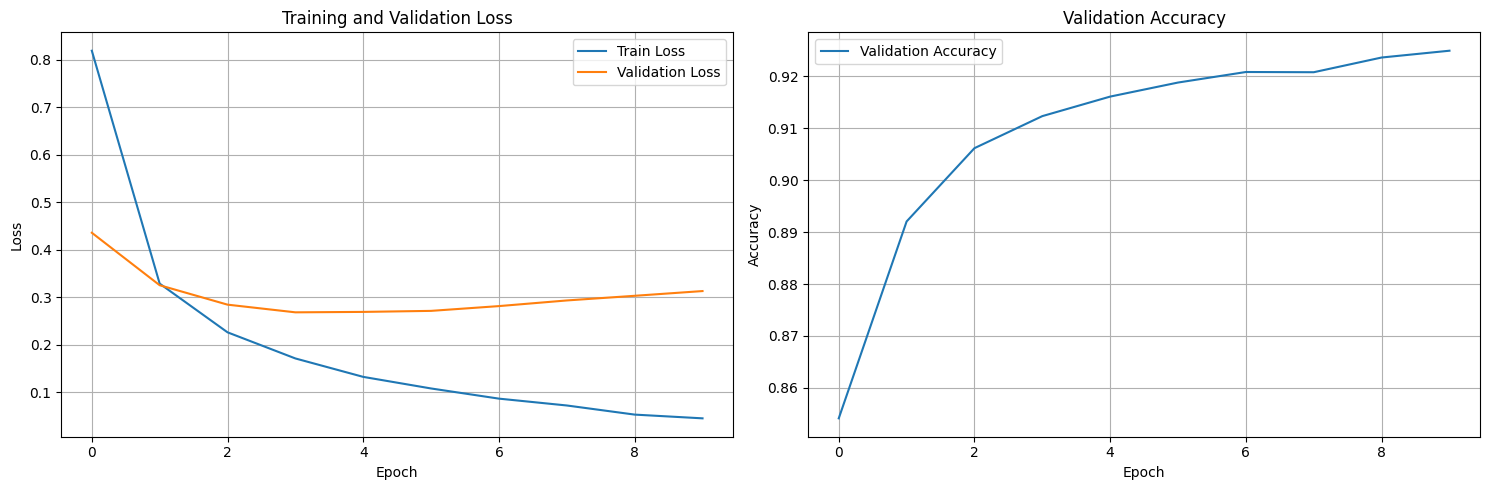

In [ ]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 6. Evaluation trên Test Set


In [ ]:
# Đánh giá trên test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.2679
Test Accuracy: 0.9261


## 7. Testing trên câu mẫu


In [ ]:
def predict_tags(model, sentence, word_to_idx, idx_to_tag, device):
    """Dự đoán POS tags cho một câu"""
    model.eval()

    # Preprocess sentence
    words = sentence.lower().split()
    word_indices = [word_to_idx.get(word, 1) for word in words]  # 1 = <UNK>

    # Convert to tensor
    word_tensor = torch.tensor([word_indices], dtype=torch.long).to(device)
    lengths = torch.tensor([len(word_indices)], dtype=torch.long)

    # Predict
    with torch.no_grad():
        outputs = model(word_tensor, lengths)
        predictions = outputs.argmax(dim=2)

    # Convert to tags
    predicted_tags = [idx_to_tag[idx.item()] for idx in predictions[0]]

    return list(zip(words, predicted_tags))

# Test trên một số câu mẫu
test_sentences = [
    "The quick brown fox jumps over the lazy dog",
    "I love natural language processing",
    "Machine learning is fascinating",
    "The cat sat on the mat"
]

print("Kết quả dự đoán POS tags:\n")
for sentence in test_sentences:
    predictions = predict_tags(model, sentence, word_to_idx, idx_to_tag, device)
    print(f"Câu: {sentence}")
    print("Tags:", " ".join([f"{word}/{tag}" for word, tag in predictions]))
    print()


Kết quả dự đoán POS tags:

Câu: The quick brown fox jumps over the lazy dog
Tags: the/DET quick/PROPN brown/PROPN fox/PROPN jumps/PROPN over/ADP the/DET lazy/NOUN dog/NOUN

Câu: I love natural language processing
Tags: i/PRON love/VERB natural/NUM language/NOUN processing/NOUN

Câu: Machine learning is fascinating
Tags: machine/NOUN learning/VERB is/AUX fascinating/PROPN

Câu: The cat sat on the mat
Tags: the/DET cat/NOUN sat/VERB on/ADP the/DET mat/NOUN



## 8. So sánh với Ground Truth


In [ ]:
# So sánh với một số câu trong test set
print("So sánh dự đoán với ground truth:\n")
for i in range(min(5, len(test_data))):
    sentence = test_data[i]
    words = [word.lower() for word, _ in sentence]
    true_tags = [tag for _, tag in sentence]

    # Predict
    sentence_str = " ".join(words)
    predictions = predict_tags(model, sentence_str, word_to_idx, idx_to_tag, device)
    pred_tags = [tag for _, tag in predictions]

    print(f"Câu {i+1}:")
    print(f"  Words: {words}")
    print(f"  True Tags: {true_tags}")
    print(f"  Pred Tags: {pred_tags}")

    # Tính accuracy cho câu này
    correct = sum(1 for t, p in zip(true_tags, pred_tags) if t == p)
    acc = correct / len(true_tags) if len(true_tags) > 0 else 0
    print(f"  Accuracy: {acc:.2%}")
    print()


So sánh dự đoán với ground truth:

Câu 1:
  Words: ['what', 'if', 'google', 'morphed', 'into', 'googleos', '?']
  True Tags:  ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']
  Pred Tags: ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'NOUN', 'PUNCT']
  Accuracy: 85.71%

Câu 2:
  Words: ['what', 'if', 'google', 'expanded', 'on', 'its', 'search', '-', 'engine', '(', 'and', 'now', 'e-mail', ')', 'wares', 'into', 'a', 'full', '-', 'fledged', 'operating', 'system', '?']
  True Tags:  ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'NOUN', 'PUNCT', 'NOUN', 'ADP', 'DET', 'ADV', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
  Pred Tags: ['PRON', 'SCONJ', 'VERB', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'NOUN', 'PUNCT', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT']
  Accuracy: 82.61%

Câu 3:
  Words: ['[', 'via', 'microsoft', 'watch', 'from', 'mary', 'jo', 'foley', ']']
  True Tags:  